In [58]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import datetime
from dateutil import relativedelta

Populating the interactive namespace from numpy and matplotlib


C:\Python27\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:

wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
print(wage.head())

            WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5


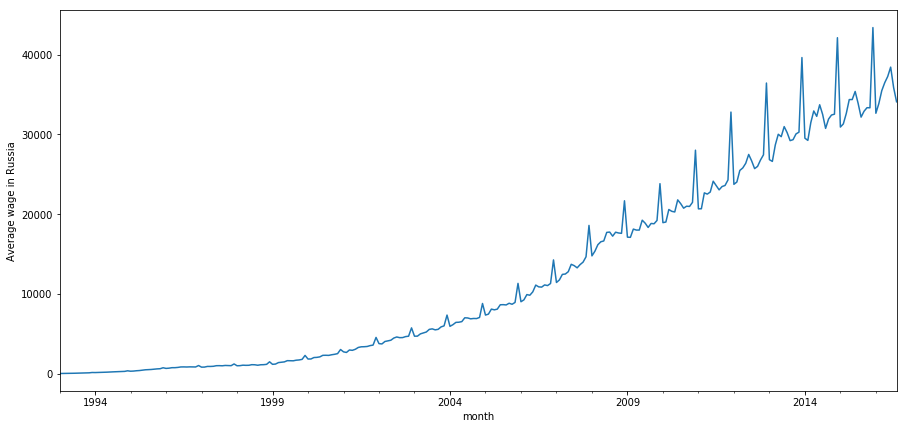

In [9]:
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel('Average wage in Russia')
pylab.show()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

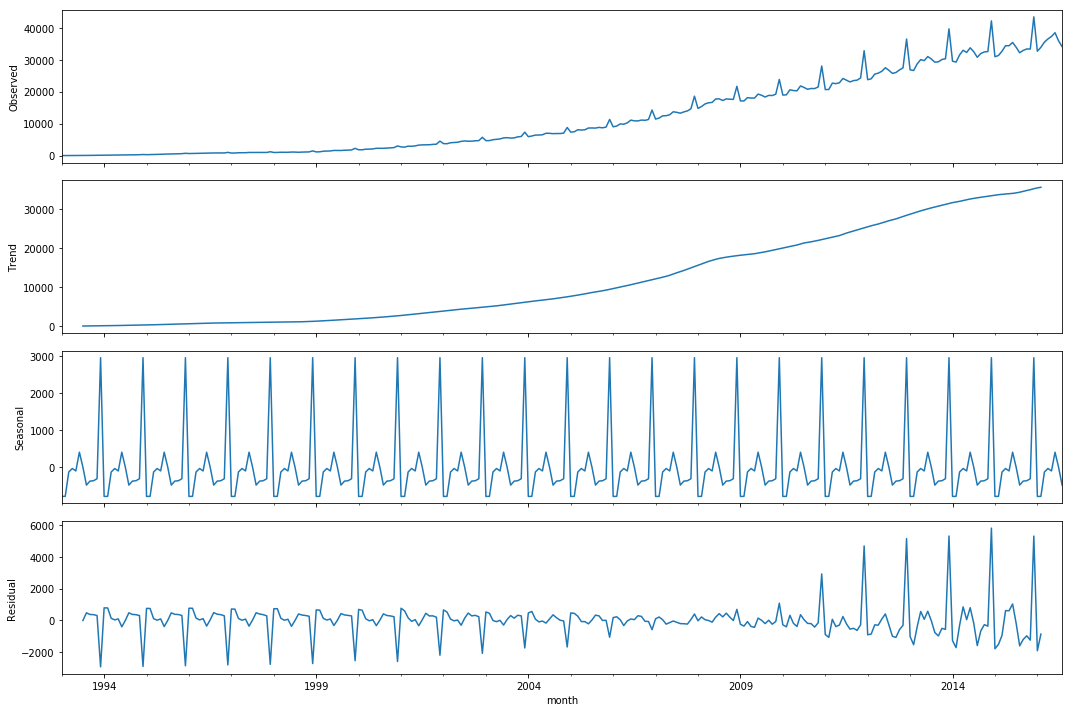

In [13]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


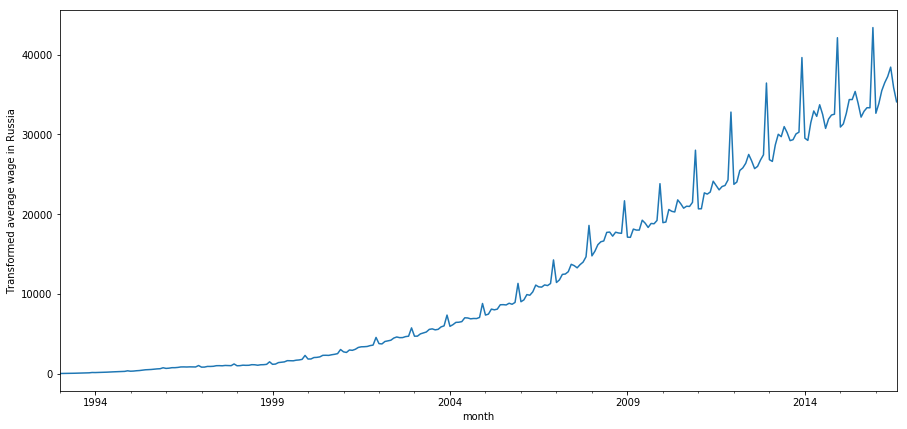

In [18]:

wage['sales_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel(u'Transformed average wage in Russia')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.sales_box)[1])


It`s still non-stationary signal, so we can use seasonal differentiation (lag = 12) to get rid of the trend.

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

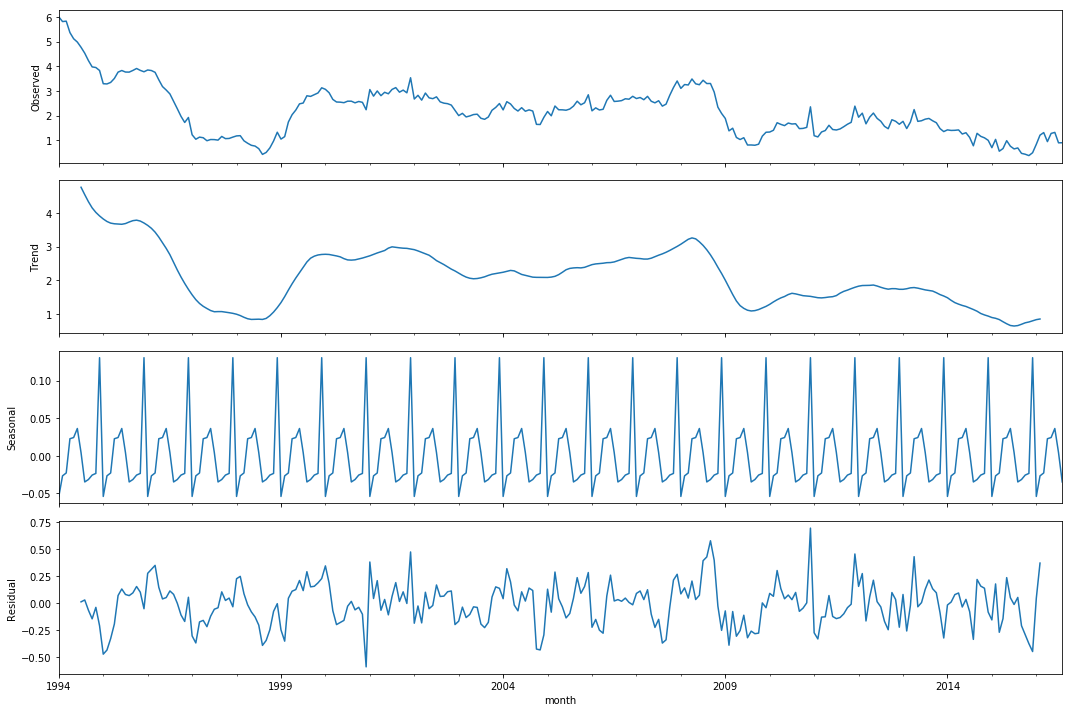

In [19]:
wage['sales_box_diff'] = wage.sales_box - wage.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.sales_box_diff[12:])[1])


Now the Dickey-Fuller test shows that the signal now is stationary, but we can do even better by adding simple differentiation (lag = 1).


Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

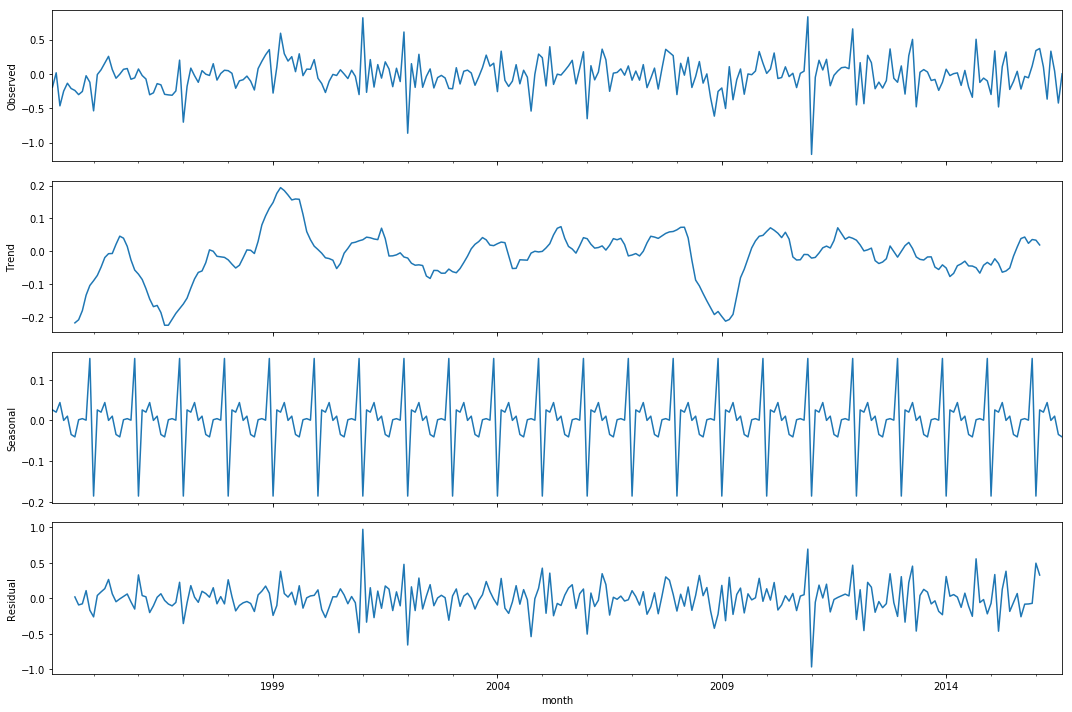

In [21]:
wage['sales_box_diff2'] = wage.sales_box_diff - wage.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.sales_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.sales_box_diff2[13:])[1])


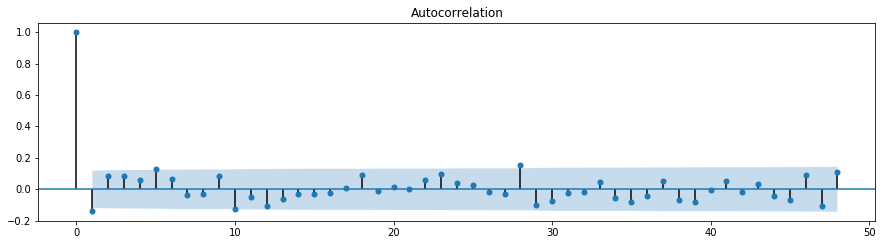

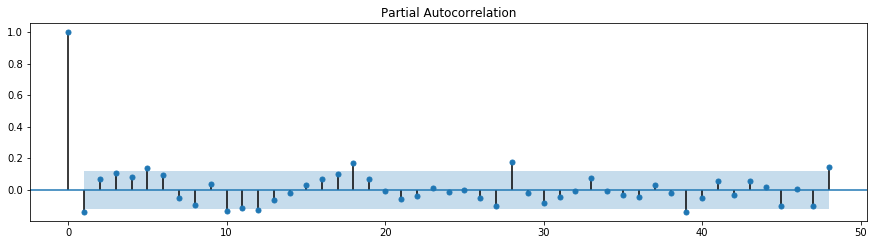

In [22]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [61]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2) 
 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [62]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
Wall time: 20 s


In [63]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
30  (3, 1, 1, 0) -4.995859
29  (3, 1, 0, 1) -4.342767
31  (3, 1, 1, 1) -4.312787
38  (4, 1, 1, 0) -3.975974
37  (4, 1, 0, 1) -3.362303


In [64]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Sun, 09 Jun 2019   AIC                             -4.996
Time:                                    11:27:13   BIC                             16.617
Sample:                                01-01-1993   HQIC                             3.682
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4854      0.210      2.313      0.021       0.074       0.897
ar.L2          0.1630      0.075   

Критерий Стьюдента: p=0.281927
Критерий Дики-Фуллера: p=0.000000


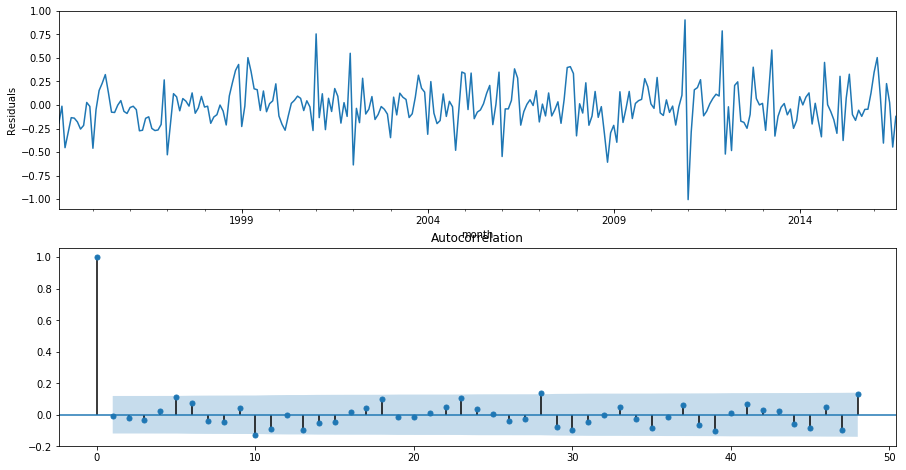

In [65]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Несмещённость остатков подтверждается критерием Стьюдента, стационарность - критерием Дики-Фуллера, а неавтокоррелированность - коррелограммой

Text(0,0.5,'wage')

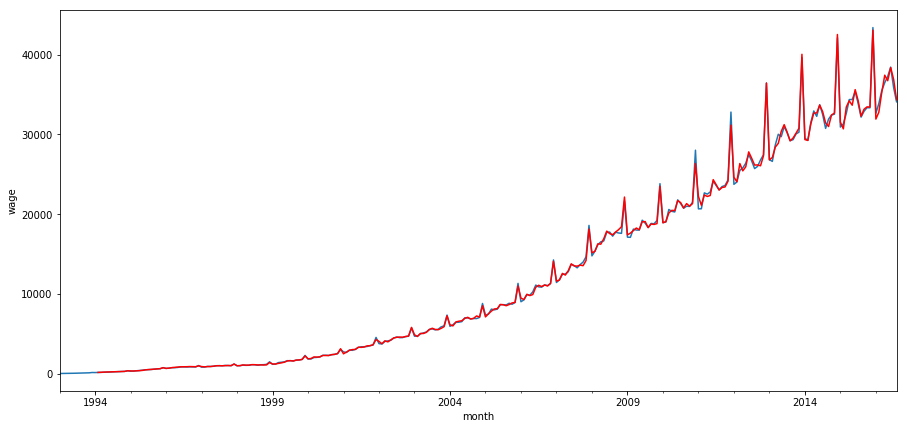

In [66]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('wage')

In [71]:
wages2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta.relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wages2.columns)
wages2 = pd.concat([wages2, future])
wages2['forecast'] = invboxcox(best_model.predict(start=284, end=309), lmbda)

plt.figure(figsize=(15,7))
wages2.WAG_C_M.plot()
wages2.forecast.plot(color='r')
plt.ylabel('wages')



NameError: name 'df' is not defined

Прогноз выглядит адекватным, соответствует тренду и передает информацию о сезонности